In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from keras.regularizers import l2

import numpy as np
from PIL import Image
import MinePI
import random

# Deep Learning
## Assignment 2: Image Generation
**Student Name:** Patrick Dorrian   
**Student ID:**   17372533   
**Class:** 1MAI MSc Artificial Intelligence


## Task 1: Choosing a Dataset
### Task Description
Choose or create a dataset of images (no labels needed), briefly describe it, load it, and show 9 samples from the dataset in a 3x3 grid. Include a URL or download instructions for the dataset. Very briefly state a possible application where you might need to generate new samples from this dataset. The images don’t have to be large. Optional: if you prefer to work on a different type of data instead of images, such as audio, time-series, or something else, contact the lecturer first with details.

### Description of Chosen Dataset
The chosen dataset is 960,000 player skins from the video game Minecraft. The appearance of a Minecraft player's avatar is determined by a 64x64 RGBA image which maps to a 3D player model. The upper half of the image is the base player skin and the bottom half is an optional second layer, which allows a layer of depth to be added to the model. I chose to crop the skins so that only the top half is used, reducing the size of the image while losing very little detail as the optional second layer is seldom utilised anyway.

### How to Download Dataset
This dataset is made available by Reddit user u/SHA65536.

https://www.reddit.com/r/datasets/comments/cmccb8/minecraft_skins_image_dataset/

### Loading the Dataset

In [3]:
IMG_DIMS = (32, 64, 4)
BATCH_SIZE = 32

def preprocess(image_data):
    image_data /= 255.0
    return image_data

image_data_generator = ImageDataGenerator(preprocessing_function=preprocess)
image_data = image_data_generator.flow_from_directory(".",
                                                    target_size=IMG_DIMS[:-1],
                                                    color_mode="rgba",
                                                    classes=["skins32"],
                                                    class_mode="input",
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE)

Found 945061 images belonging to 1 classes.


### Samples from Dataset
The skins are mapped to 3D Minecraft models in order to make the output comprehensible.

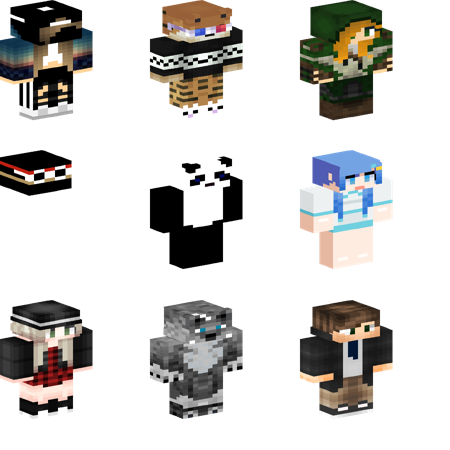

In [4]:
async def skin_grid(img_batch, size=(3,3), output_size=(450, 450), **kwargs):
    cols, rows = size
    w, h = 300, 500
    grid = Image.new('RGBA', size=(cols*w, rows*h))
    
    imgs = img_batch[:cols*rows, ...]
    imgs *= 255
    imgs = imgs.astype(np.uint8)
    
    for i, img in enumerate(imgs):
        skin = Image.fromarray(img)
        model = await MinePI.render_3d_skin(skin_image=skin, **kwargs)
        grid.paste(model, box=(i%cols*w, i//cols*h))
        
    return grid.resize(output_size)

await skin_grid(next(image_data)[0])

### A Possible Application of Generated Images
One scenario in which new samples may need to be generated is if someone wanted to make a procedurally generated roleplaying mod for Minecraft with unique characters.

## Task 2: Model Creation
### Task Description
Using Keras, build an auto-encoder (AE), a variational auto-encoder (VAE), and a generative adversarial
network (GAN), and train them on the data. You can reuse existing code (not pretrained models) but
you must include URLs or other citation for any substantial reuse of existing code. IMPORTANT: all
three models must use the same architecture for the image-generation part (i.e. the decoder for AE
and VAE, or the generator for the GAN) and use consistent approach and style throughout, i.e. must
NOT just be different models from different sources, pasted together. This is to ensure fair comparison.   
   
If necessary, try out different hyperparameters, training methods, etc., in order to achieve successful
training.

### Auto-Encoder

In [5]:
latent_dim = 128

# Encoder architecture
input_image = layers.Input((32, 64, 4))
x = layers.Conv2D(32, 3, strides=2)(input_image)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2D(32, 3)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(64, 3, strides=2)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2D(64, 3)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)


x = layers.Conv2D(128, 3)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)

# Latent space
z = layers.Dense(latent_dim)(x)

# Decoder architecture
x = layers.Dense(512)(z)
x = layers.Reshape((2, 4, 64))(x)
x = layers.Conv2DTranspose(1024, 3, strides=2, padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(512, 3, strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(512, 3, strides=2, padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 3, strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(128, 3,padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

output_image = layers.Conv2DTranspose(4, 3, padding="same",activation="tanh")(x)

# Models
encoder = tf.keras.models.Model(input_image, z, name="encoder")
decoder = tf.keras.models.Model(z, output_image, name="decoder")
autoencoder = tf.keras.models.Model(input_image, output_image, name="autoencoder")

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 15, 31, 32)        1184      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 15, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 29, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 13, 29, 32)        0         
                                                                 
 dropout (Dropout)           (None, 13, 29, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 14, 64)         

In [6]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse", metrics=["accuracy"])

In [7]:
# Train model
autoencoder.fit(image_data, epochs=100, steps_per_epoch=100, batch_size=32)

Epoch 1/100
100/100 [==============================] - 34s 237ms/step - loss: 0.0852 - accuracy: 0.5996
Epoch 2/100
100/100 [==============================] - 24s 240ms/step - loss: 0.0523 - accuracy: 0.5985
Epoch 3/100
100/100 [==============================] - 24s 242ms/step - loss: 0.0428 - accuracy: 0.6184
Epoch 4/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0398 - accuracy: 0.6224
Epoch 5/100
100/100 [==============================] - 24s 244ms/step - loss: 0.0369 - accuracy: 0.6144
Epoch 6/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0343 - accuracy: 0.6308
Epoch 7/100
100/100 [==============================] - 24s 242ms/step - loss: 0.0321 - accuracy: 0.6278
Epoch 8/100
100/100 [==============================] - 24s 242ms/step - loss: 0.0311 - accuracy: 0.6349
Epoch 9/100
100/100 [==============================] - 24s 242ms/step - loss: 0.0297 - accuracy: 0.6370
Epoch 10/100
100/100 [==============================] - 24s 242m

100/100 [==============================] - 24s 243ms/step - loss: 0.0193 - accuracy: 0.6532
Epoch 80/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0189 - accuracy: 0.6519
Epoch 81/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0187 - accuracy: 0.6515
Epoch 82/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0184 - accuracy: 0.6601
Epoch 83/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0185 - accuracy: 0.6624
Epoch 84/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0185 - accuracy: 0.6481
Epoch 85/100
100/100 [==============================] - 24s 244ms/step - loss: 0.0187 - accuracy: 0.6478
Epoch 86/100
100/100 [==============================] - 24s 244ms/step - loss: 0.0185 - accuracy: 0.6524
Epoch 87/100
100/100 [==============================] - 24s 244ms/step - loss: 0.0186 - accuracy: 0.6562
Epoch 88/100
100/100 [==============================] - 24s 243ms/st

In [8]:
autoencoder.save('checkpoints/ae011_35000')
decoder.save('checkpoints/decoder011_35000')

INFO:tensorflow:Assets written to: checkpoints/ae011_35000\assets
INFO:tensorflow:Assets written to: checkpoints/decoder011_35000\assets


### Variational Auto-Encoder

In [9]:
# Sampling layer from given example
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 128

# Encoder architecture
input_image = layers.Input((32, 64, 4))
x = layers.Conv2D(32, 3, strides=2)(input_image)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2D(32, 3)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(64, 3, strides=2)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2D(64, 3)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)


x = layers.Conv2D(128, 3)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)

# Latent space
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

# Decoder architecture
x = layers.Dense(512)(z)
x = layers.Reshape((2, 4, 64))(x)
x = layers.Conv2DTranspose(1024, 3, strides=2, padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(512, 3, strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(512, 3, strides=2, padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 3, strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(128, 3,padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

output_image = layers.Conv2DTranspose(4, 3, padding="same",activation="tanh")(x)

# Models
encoder = tf.keras.models.Model(input_image, z, name="encoder")
decoder = tf.keras.models.Model(z, output_image, name="decoder")
vae = tf.keras.models.Model(input_image, output_image, name="autoencoder")

vae.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 64, 4)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 15, 31, 32)   1184        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)     (None, 15, 31, 32)   0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 13, 29, 32)   9248        ['leaky_re_lu_10[0][0]']         
                                                                                        

In [10]:
# Implementation of Kublick-Leibler loss from given example
reconstruction_loss = mse(input_image, output_image)
reconstruction_loss = 32 * 64 * K.mean(reconstruction_loss)
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

vae.add_loss(kl_loss)
vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
vae.add_loss(reconstruction_loss)
vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=optimizer, metrics=["accuracy"])

In [11]:
# Train model
vae.fit(image_data, epochs=500, steps_per_epoch=1000, batch_size=32)

Epoch 1/500
1000/1000 [==============================] - 246s 245ms/step - loss: 117.0470 - accuracy: 0.6132 - kl_loss: 1.8738 - mse_loss: 115.1732
Epoch 2/500
1000/1000 [==============================] - 245s 245ms/step - loss: 74.4716 - accuracy: 0.6341 - kl_loss: 1.8784 - mse_loss: 72.5932
Epoch 3/500
1000/1000 [==============================] - 245s 245ms/step - loss: 62.5723 - accuracy: 0.6442 - kl_loss: 1.9827 - mse_loss: 60.5896
Epoch 4/500
1000/1000 [==============================] - 245s 245ms/step - loss: 57.3292 - accuracy: 0.6468 - kl_loss: 1.9994 - mse_loss: 55.3299
Epoch 5/500
1000/1000 [==============================] - 245s 245ms/step - loss: 54.4255 - accuracy: 0.6502 - kl_loss: 1.9957 - mse_loss: 52.4298
Epoch 6/500
1000/1000 [==============================] - 245s 245ms/step - loss: 51.9629 - accuracy: 0.6425 - kl_loss: 2.0122 - mse_loss: 49.9507
Epoch 7/500
1000/1000 [==============================] - 245s 245ms/step - loss: 49.9123 - accuracy: 0.6422 - kl_loss: 2.0

1000/1000 [==============================] - 246s 246ms/step - loss: 30.5905 - accuracy: 0.6564 - kl_loss: 2.0523 - mse_loss: 28.5381
Epoch 112/500
1000/1000 [==============================] - 246s 246ms/step - loss: 31.0760 - accuracy: 0.6534 - kl_loss: 2.0593 - mse_loss: 29.0166
Epoch 113/500
1000/1000 [==============================] - 246s 246ms/step - loss: 30.3820 - accuracy: 0.6577 - kl_loss: 2.0476 - mse_loss: 28.3344
Epoch 114/500
1000/1000 [==============================] - 246s 246ms/step - loss: 30.7341 - accuracy: 0.6598 - kl_loss: 2.0549 - mse_loss: 28.6791
Epoch 115/500
1000/1000 [==============================] - 246s 246ms/step - loss: 30.5772 - accuracy: 0.6611 - kl_loss: 2.0512 - mse_loss: 28.5260
Epoch 116/500
1000/1000 [==============================] - 246s 246ms/step - loss: 30.4727 - accuracy: 0.6600 - kl_loss: 2.0554 - mse_loss: 28.4174
Epoch 117/500
1000/1000 [==============================] - 245s 245ms/step - loss: 30.7276 - accuracy: 0.6534 - kl_loss: 2.060

KeyboardInterrupt: 

In [ ]:
vae.save('checkpoints/vae011_50000')
decoder.save('checkpoints/vdecoder011_50000')

### Generative Adversarial Network

In [10]:
latent_dim = 128

# Generator architecture
input_noise = layers.Input(latent_dim)

x = layers.Dense(512)(input_noise)
x = layers.Reshape((2, 4, 64))(x)
x = layers.Conv2DTranspose(1024, 3, strides=2, padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(512, 3, strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(512, 3, strides=2, padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 3, strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(128, 3,padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

generated_image = layers.Conv2DTranspose(4, 3, padding="same",activation="tanh")(x)

# Discriminator architecture
input_image = layers.Input((32, 64, 4))
x = layers.Conv2D(32, 3, strides=2)(input_image)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2D(32, 3)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(64, 3, strides=2)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Conv2D(64, 3)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)


x = layers.Conv2D(128, 3)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
prediction = layers.Dense(1, activation="sigmoid")(x)

# Models
generator = tf.keras.models.Model(input_noise, generated_image, name="generator")
discriminator = tf.keras.models.Model(input_image, prediction, name="discriminator")
gan = tf.keras.models.Model(input_noise, discriminator(generator(input_noise)), name="gan")

gan.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 512)               66048     
                                                                 
 reshape_1 (Reshape)         (None, 2, 4, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 4, 8, 1024)       590848    
 ranspose)                                                       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 4, 8, 1024)        0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 8, 16, 512)       4719104   
 ranspose)                                               

In [11]:
# Compile discriminator
optimizer = tf.keras.optimizers.Adam(0.00005, beta_1=0.5)
discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Compile GAN
discriminator.trainable = False    # Freeze discriminator for generator training
optimizer = tf.keras.optimizers.Adam(0.00005, beta_1=0.5)
gan.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 generator (Functional)      (None, 32, 64, 4)         9215364   
                                                                 
 discriminator (Functional)  (None, 1)                 795585    
                                                                 
Total params: 10,010,949
Trainable params: 9,215,364
Non-trainable params: 795,585
_________________________________________________________________


In [12]:
steps=100000
tf.config.run_functions_eagerly(True)

# Training loop
fake_labels = np.ones((BATCH_SIZE, 1))
real_labels = np.zeros((BATCH_SIZE, 1))
for step in range(steps):
    # Reset image generator if end is reached
    try:
        real_images = next(image_data)[0]
        if real_images.shape[0] < 32:
            continue
    except StopIteration:
        print('End of the line.')
        image_data = image_data_generator.flow_from_directory(".",
                                                    target_size=IMG_DIMS[:-1],
                                                    color_mode="rgba",
                                                    classes=["skins32"],
                                                    class_mode="input",
                                                    batch_size=BATCH_SIZE)
        real_images = next(image_data)[0]
    
    # Generate fake images
    noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
    fake_images = generator.predict(noise)
    
    # Train discriminator on real and fake images
    loss_d_real = discriminator.train_on_batch(real_images, real_labels, return_dict=True)
    loss_d_fake = discriminator.train_on_batch(fake_images, fake_labels, return_dict=True)
    
    # Train generator to fool discriminator
    loss_g = gan.train_on_batch(noise, real_labels, return_dict=True)
    
    # Print progress every 100 steps
    if step % 100 == 0:
        print(f"{step/steps:.2%}\t{step}/{steps}\nD_real={loss_d_real}\nD_fake={loss_d_fake}\nGAN={loss_g}")
    
    # Save sample of outputs
    if step%1000==0 and step!=0:
        noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
        x = generator.predict(noise)
        g = await skin_grid(x)
        g.save(f'figures/gan006b_{step}.png')
        
    # Save models
    if step%5000==0 and step!=0:
        gan.save(f'checkpoints/gan006b_{step}')
        generator.save(f'checkpoints/generator006b_{step}')
        discriminator.save(f'checkpoints/discriminator006b_{step}')

0.00%	0/100000
D_real={'loss': 0.2332439124584198, 'accuracy': 0.6875}
D_fake={'loss': 0.25061148405075073, 'accuracy': 0.125}
GAN={'loss': 0.24939066171646118, 'accuracy': 0.9375}
0.10%	100/100000
D_real={'loss': 0.025520270690321922, 'accuracy': 0.96875}
D_fake={'loss': 0.2028445452451706, 'accuracy': 1.0}
GAN={'loss': 0.30584919452667236, 'accuracy': 0.03125}
0.20%	200/100000
D_real={'loss': 0.22877570986747742, 'accuracy': 0.71875}
D_fake={'loss': 0.22874531149864197, 'accuracy': 0.6875}
GAN={'loss': 0.4129343330860138, 'accuracy': 0.21875}
0.30%	300/100000
D_real={'loss': 0.22959750890731812, 'accuracy': 0.6875}
D_fake={'loss': 0.2477799654006958, 'accuracy': 0.53125}
GAN={'loss': 0.33691978454589844, 'accuracy': 0.25}
0.40%	400/100000
D_real={'loss': 0.21505475044250488, 'accuracy': 0.6875}
D_fake={'loss': 0.249301478266716, 'accuracy': 0.5625}
GAN={'loss': 0.29803621768951416, 'accuracy': 0.375}
0.50%	500/100000
D_real={'loss': 0.20596373081207275, 'accuracy': 0.71875}
D_fake={'

4.50%	4500/100000
D_real={'loss': 0.21052499115467072, 'accuracy': 0.65625}
D_fake={'loss': 0.22628314793109894, 'accuracy': 0.75}
GAN={'loss': 0.3310427963733673, 'accuracy': 0.1875}
4.60%	4600/100000
D_real={'loss': 0.2276737093925476, 'accuracy': 0.59375}
D_fake={'loss': 0.23757368326187134, 'accuracy': 0.59375}
GAN={'loss': 0.2930428981781006, 'accuracy': 0.3125}
4.70%	4700/100000
D_real={'loss': 0.17962650954723358, 'accuracy': 0.75}
D_fake={'loss': 0.18453986942768097, 'accuracy': 0.875}
GAN={'loss': 0.3827586770057678, 'accuracy': 0.0625}
4.80%	4800/100000
D_real={'loss': 0.26334041357040405, 'accuracy': 0.4375}
D_fake={'loss': 0.19523707032203674, 'accuracy': 0.8125}
GAN={'loss': 0.34187713265419006, 'accuracy': 0.15625}
4.90%	4900/100000
D_real={'loss': 0.24792630970478058, 'accuracy': 0.53125}
D_fake={'loss': 0.13991639018058777, 'accuracy': 1.0}
GAN={'loss': 0.3508455753326416, 'accuracy': 0.21875}
5.00%	5000/100000
D_real={'loss': 0.24171388149261475, 'accuracy': 0.46875}
D

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5.10%	5100/100000
D_real={'loss': 0.24755427241325378, 'accuracy': 0.5625}
D_fake={'loss': 0.23233065009117126, 'accuracy': 0.65625}
GAN={'loss': 0.3109714090824127, 'accuracy': 0.28125}
5.20%	5200/100000
D_real={'loss': 0.24971747398376465, 'accuracy': 0.4375}
D_fake={'loss': 0.21838371455669403, 'accuracy': 0.6875}
GAN={'loss': 0.3340379595756531, 'accuracy': 0.34375}
5.30%	5300/100000
D_real={'loss': 0.2624441981315613, 'accuracy': 0.53125}
D_fake={'loss': 0.18497124314308167, 'accuracy': 0.78125}
GAN={'loss': 0.3099799156188965, 'accuracy': 0.28125}
5.40%	5400/100000
D_real={'loss': 0.1775760054588318, 'accuracy': 0.6875}
D_fake={'loss': 0.19410072267055511, 'accuracy': 0.78125}
GAN={'loss': 0.31326931715011597, 'accuracy': 0.25}
5.50%	5500/100000
D_real={'loss': 0.254684180021286, 'accuracy': 0.4375}
D_fake={'loss': 0.22467903792858124, 'accuracy': 0.59375}
GAN={'loss': 0.35688191652297974, 'accuracy': 0.25}
5.60%	5600/100000
D_real={'loss': 0.1748771220445633, 'accuracy': 0.65625

9.60%	9600/100000
D_real={'loss': 0.22581011056900024, 'accuracy': 0.5}
D_fake={'loss': 0.10401171445846558, 'accuracy': 0.96875}
GAN={'loss': 0.4587012529373169, 'accuracy': 0.09375}
9.70%	9700/100000
D_real={'loss': 0.2821812033653259, 'accuracy': 0.5}
D_fake={'loss': 0.1599707305431366, 'accuracy': 0.75}
GAN={'loss': 0.3955305814743042, 'accuracy': 0.28125}
9.80%	9800/100000
D_real={'loss': 0.1699449121952057, 'accuracy': 0.71875}
D_fake={'loss': 0.17511340975761414, 'accuracy': 0.78125}
GAN={'loss': 0.558037281036377, 'accuracy': 0.03125}
9.90%	9900/100000
D_real={'loss': 0.1888936460018158, 'accuracy': 0.5625}
D_fake={'loss': 0.13176144659519196, 'accuracy': 0.90625}
GAN={'loss': 0.507017195224762, 'accuracy': 0.03125}
10.00%	10000/100000
D_real={'loss': 0.3349386751651764, 'accuracy': 0.34375}
D_fake={'loss': 0.18005093932151794, 'accuracy': 0.75}
GAN={'loss': 0.4537482261657715, 'accuracy': 0.09375}
INFO:tensorflow:Assets written to: checkpoints/gan006_10000\assets


C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10.10%	10100/100000
D_real={'loss': 0.24584192037582397, 'accuracy': 0.53125}
D_fake={'loss': 0.1904749721288681, 'accuracy': 0.75}
GAN={'loss': 0.4447863698005676, 'accuracy': 0.15625}
10.20%	10200/100000
D_real={'loss': 0.26093339920043945, 'accuracy': 0.5}
D_fake={'loss': 0.11438962817192078, 'accuracy': 0.90625}
GAN={'loss': 0.5410417318344116, 'accuracy': 0.0}
10.30%	10300/100000
D_real={'loss': 0.19388093054294586, 'accuracy': 0.65625}
D_fake={'loss': 0.17273035645484924, 'accuracy': 0.78125}
GAN={'loss': 0.4602121114730835, 'accuracy': 0.125}
10.40%	10400/100000
D_real={'loss': 0.282157838344574, 'accuracy': 0.375}
D_fake={'loss': 0.11846358329057693, 'accuracy': 0.9375}
GAN={'loss': 0.4006790518760681, 'accuracy': 0.15625}
10.50%	10500/100000
D_real={'loss': 0.1420159935951233, 'accuracy': 0.75}
D_fake={'loss': 0.2015356570482254, 'accuracy': 0.75}
GAN={'loss': 0.40169060230255127, 'accuracy': 0.3125}
10.60%	10600/100000
D_real={'loss': 0.20861691236495972, 'accuracy': 0.5625}


14.50%	14500/100000
D_real={'loss': 0.18169736862182617, 'accuracy': 0.71875}
D_fake={'loss': 0.1111232191324234, 'accuracy': 0.90625}
GAN={'loss': 0.497513085603714, 'accuracy': 0.09375}
14.60%	14600/100000
D_real={'loss': 0.11796277016401291, 'accuracy': 0.78125}
D_fake={'loss': 0.12488970160484314, 'accuracy': 0.875}
GAN={'loss': 0.4497484266757965, 'accuracy': 0.1875}
14.70%	14700/100000
D_real={'loss': 0.18309864401817322, 'accuracy': 0.65625}
D_fake={'loss': 0.11177308112382889, 'accuracy': 0.90625}
GAN={'loss': 0.5146937966346741, 'accuracy': 0.09375}
14.80%	14800/100000
D_real={'loss': 0.1408780813217163, 'accuracy': 0.75}
D_fake={'loss': 0.11451756954193115, 'accuracy': 0.9375}
GAN={'loss': 0.5065426230430603, 'accuracy': 0.09375}
14.90%	14900/100000
D_real={'loss': 0.22974905371665955, 'accuracy': 0.65625}
D_fake={'loss': 0.11168272793292999, 'accuracy': 0.90625}
GAN={'loss': 0.5068279504776001, 'accuracy': 0.125}
15.00%	15000/100000
D_real={'loss': 0.2199629545211792, 'accur

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15.10%	15100/100000
D_real={'loss': 0.16281698644161224, 'accuracy': 0.75}
D_fake={'loss': 0.2048722803592682, 'accuracy': 0.78125}
GAN={'loss': 0.4877038300037384, 'accuracy': 0.125}
15.20%	15200/100000
D_real={'loss': 0.24841538071632385, 'accuracy': 0.5}
D_fake={'loss': 0.13576439023017883, 'accuracy': 0.875}
GAN={'loss': 0.5026885271072388, 'accuracy': 0.125}
15.30%	15300/100000
D_real={'loss': 0.1846706122159958, 'accuracy': 0.65625}
D_fake={'loss': 0.12109293788671494, 'accuracy': 0.8125}
GAN={'loss': 0.5172367095947266, 'accuracy': 0.09375}
15.40%	15400/100000
D_real={'loss': 0.21488350629806519, 'accuracy': 0.59375}
D_fake={'loss': 0.10458776354789734, 'accuracy': 0.8125}
GAN={'loss': 0.6507853269577026, 'accuracy': 0.0625}
15.50%	15500/100000
D_real={'loss': 0.24968641996383667, 'accuracy': 0.5625}
D_fake={'loss': 0.13991305232048035, 'accuracy': 0.84375}
GAN={'loss': 0.5139001607894897, 'accuracy': 0.0}
15.60%	15600/100000
D_real={'loss': 0.2274167537689209, 'accuracy': 0.656

19.50%	19500/100000
D_real={'loss': 0.2516075372695923, 'accuracy': 0.59375}
D_fake={'loss': 0.14052116870880127, 'accuracy': 0.875}
GAN={'loss': 0.5161970853805542, 'accuracy': 0.0625}
19.60%	19600/100000
D_real={'loss': 0.21115493774414062, 'accuracy': 0.65625}
D_fake={'loss': 0.06688253581523895, 'accuracy': 0.96875}
GAN={'loss': 0.587104320526123, 'accuracy': 0.0625}
19.70%	19700/100000
D_real={'loss': 0.12930689752101898, 'accuracy': 0.75}
D_fake={'loss': 0.15695849061012268, 'accuracy': 0.8125}
GAN={'loss': 0.6017411947250366, 'accuracy': 0.0625}
19.80%	19800/100000
D_real={'loss': 0.21082362532615662, 'accuracy': 0.625}
D_fake={'loss': 0.07859634608030319, 'accuracy': 0.9375}
GAN={'loss': 0.5426568388938904, 'accuracy': 0.15625}
19.90%	19900/100000
D_real={'loss': 0.31486159563064575, 'accuracy': 0.46875}
D_fake={'loss': 0.14279629290103912, 'accuracy': 0.84375}
GAN={'loss': 0.47324204444885254, 'accuracy': 0.0625}
20.00%	20000/100000
D_real={'loss': 0.20145300030708313, 'accura

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


20.10%	20100/100000
D_real={'loss': 0.1984683871269226, 'accuracy': 0.71875}
D_fake={'loss': 0.08570808917284012, 'accuracy': 0.9375}
GAN={'loss': 0.560388445854187, 'accuracy': 0.0625}
20.20%	20200/100000
D_real={'loss': 0.1641377955675125, 'accuracy': 0.65625}
D_fake={'loss': 0.1423916071653366, 'accuracy': 0.875}
GAN={'loss': 0.5545968413352966, 'accuracy': 0.0625}
20.30%	20300/100000
D_real={'loss': 0.105075404047966, 'accuracy': 0.8125}
D_fake={'loss': 0.20832312107086182, 'accuracy': 0.71875}
GAN={'loss': 0.5388847589492798, 'accuracy': 0.125}
20.40%	20400/100000
D_real={'loss': 0.20039018988609314, 'accuracy': 0.65625}
D_fake={'loss': 0.12538717687129974, 'accuracy': 0.875}
GAN={'loss': 0.5189221501350403, 'accuracy': 0.15625}
20.50%	20500/100000
D_real={'loss': 0.24398250877857208, 'accuracy': 0.625}
D_fake={'loss': 0.10489104688167572, 'accuracy': 0.875}
GAN={'loss': 0.6073188781738281, 'accuracy': 0.0625}
20.60%	20600/100000
D_real={'loss': 0.17499271035194397, 'accuracy': 0.

24.50%	24500/100000
D_real={'loss': 0.2038421481847763, 'accuracy': 0.65625}
D_fake={'loss': 0.11011143028736115, 'accuracy': 0.9375}
GAN={'loss': 0.538120687007904, 'accuracy': 0.15625}
24.60%	24600/100000
D_real={'loss': 0.230143740773201, 'accuracy': 0.65625}
D_fake={'loss': 0.09555311501026154, 'accuracy': 0.9375}
GAN={'loss': 0.5761207342147827, 'accuracy': 0.03125}
24.70%	24700/100000
D_real={'loss': 0.17648695409297943, 'accuracy': 0.6875}
D_fake={'loss': 0.10375147312879562, 'accuracy': 0.9375}
GAN={'loss': 0.5937871932983398, 'accuracy': 0.03125}
24.80%	24800/100000
D_real={'loss': 0.2496567666530609, 'accuracy': 0.5625}
D_fake={'loss': 0.07290733605623245, 'accuracy': 0.9375}
GAN={'loss': 0.6024278402328491, 'accuracy': 0.03125}
24.90%	24900/100000
D_real={'loss': 0.2097405344247818, 'accuracy': 0.59375}
D_fake={'loss': 0.07853451371192932, 'accuracy': 0.9375}
GAN={'loss': 0.5808655023574829, 'accuracy': 0.09375}
25.00%	25000/100000
D_real={'loss': 0.2218078374862671, 'accura

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25.10%	25100/100000
D_real={'loss': 0.19781456887722015, 'accuracy': 0.71875}
D_fake={'loss': 0.09150020778179169, 'accuracy': 0.9375}
GAN={'loss': 0.5664116740226746, 'accuracy': 0.15625}
25.20%	25200/100000
D_real={'loss': 0.2917090654373169, 'accuracy': 0.5625}
D_fake={'loss': 0.07801580429077148, 'accuracy': 0.96875}
GAN={'loss': 0.6073983311653137, 'accuracy': 0.0}
25.30%	25300/100000
D_real={'loss': 0.1862424612045288, 'accuracy': 0.71875}
D_fake={'loss': 0.12596070766448975, 'accuracy': 0.90625}
GAN={'loss': 0.5652238130569458, 'accuracy': 0.0625}
25.40%	25400/100000
D_real={'loss': 0.2215423882007599, 'accuracy': 0.59375}
D_fake={'loss': 0.09028805047273636, 'accuracy': 0.90625}
GAN={'loss': 0.6306856274604797, 'accuracy': 0.0625}
25.50%	25500/100000
D_real={'loss': 0.12984800338745117, 'accuracy': 0.78125}
D_fake={'loss': 0.172038272023201, 'accuracy': 0.71875}
GAN={'loss': 0.5275606513023376, 'accuracy': 0.09375}
25.60%	25600/100000
D_real={'loss': 0.2504582405090332, 'accura

29.50%	29500/100000
D_real={'loss': 0.20208975672721863, 'accuracy': 0.65625}
D_fake={'loss': 0.11260083317756653, 'accuracy': 0.9375}
GAN={'loss': 0.5974840521812439, 'accuracy': 0.03125}
29.60%	29600/100000
D_real={'loss': 0.23696473240852356, 'accuracy': 0.59375}
D_fake={'loss': 0.14438654482364655, 'accuracy': 0.78125}
GAN={'loss': 0.5699999332427979, 'accuracy': 0.125}
29.70%	29700/100000
D_real={'loss': 0.13410454988479614, 'accuracy': 0.8125}
D_fake={'loss': 0.15109658241271973, 'accuracy': 0.75}
GAN={'loss': 0.5386057496070862, 'accuracy': 0.125}
29.80%	29800/100000
D_real={'loss': 0.19618713855743408, 'accuracy': 0.6875}
D_fake={'loss': 0.121810182929039, 'accuracy': 0.875}
GAN={'loss': 0.5949215292930603, 'accuracy': 0.03125}
29.90%	29900/100000
D_real={'loss': 0.2712451219558716, 'accuracy': 0.53125}
D_fake={'loss': 0.10194648802280426, 'accuracy': 0.875}
GAN={'loss': 0.5868345499038696, 'accuracy': 0.0625}
30.00%	30000/100000
D_real={'loss': 0.24927480518817902, 'accuracy':

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


30.10%	30100/100000
D_real={'loss': 0.16550102829933167, 'accuracy': 0.71875}
D_fake={'loss': 0.09247250854969025, 'accuracy': 0.90625}
GAN={'loss': 0.5740313529968262, 'accuracy': 0.15625}
30.20%	30200/100000
D_real={'loss': 0.22684279084205627, 'accuracy': 0.59375}
D_fake={'loss': 0.1321326345205307, 'accuracy': 0.875}
GAN={'loss': 0.6451178789138794, 'accuracy': 0.0625}
30.30%	30300/100000
D_real={'loss': 0.3072381317615509, 'accuracy': 0.5}
D_fake={'loss': 0.08420321345329285, 'accuracy': 1.0}
GAN={'loss': 0.6235119700431824, 'accuracy': 0.03125}
30.40%	30400/100000
D_real={'loss': 0.14564192295074463, 'accuracy': 0.75}
D_fake={'loss': 0.10435990989208221, 'accuracy': 0.9375}
GAN={'loss': 0.5861514806747437, 'accuracy': 0.0625}
30.50%	30500/100000
D_real={'loss': 0.13699135184288025, 'accuracy': 0.75}
D_fake={'loss': 0.1389731466770172, 'accuracy': 0.9375}
GAN={'loss': 0.5317711234092712, 'accuracy': 0.09375}
30.60%	30600/100000
D_real={'loss': 0.20102940499782562, 'accuracy': 0.65

34.60%	34600/100000
D_real={'loss': 0.20499370992183685, 'accuracy': 0.625}
D_fake={'loss': 0.10137837380170822, 'accuracy': 0.90625}
GAN={'loss': 0.530587911605835, 'accuracy': 0.03125}
34.70%	34700/100000
D_real={'loss': 0.25575822591781616, 'accuracy': 0.59375}
D_fake={'loss': 0.047406937927007675, 'accuracy': 1.0}
GAN={'loss': 0.7068556547164917, 'accuracy': 0.0}
34.80%	34800/100000
D_real={'loss': 0.20541179180145264, 'accuracy': 0.625}
D_fake={'loss': 0.11321352422237396, 'accuracy': 0.875}
GAN={'loss': 0.5363731384277344, 'accuracy': 0.1875}
34.90%	34900/100000
D_real={'loss': 0.18149778246879578, 'accuracy': 0.65625}
D_fake={'loss': 0.07643179595470428, 'accuracy': 0.96875}
GAN={'loss': 0.6435912847518921, 'accuracy': 0.0625}
35.00%	35000/100000
D_real={'loss': 0.2739374041557312, 'accuracy': 0.5625}
D_fake={'loss': 0.10912597179412842, 'accuracy': 0.84375}
GAN={'loss': 0.5741358995437622, 'accuracy': 0.125}
INFO:tensorflow:Assets written to: checkpoints/gan006_35000\assets


C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


35.10%	35100/100000
D_real={'loss': 0.28832677006721497, 'accuracy': 0.5}
D_fake={'loss': 0.11252452433109283, 'accuracy': 0.875}
GAN={'loss': 0.5875920057296753, 'accuracy': 0.0625}
35.20%	35200/100000
D_real={'loss': 0.08783289790153503, 'accuracy': 0.8125}
D_fake={'loss': 0.10684572160243988, 'accuracy': 0.90625}
GAN={'loss': 0.5856719017028809, 'accuracy': 0.09375}
35.30%	35300/100000
D_real={'loss': 0.36911851167678833, 'accuracy': 0.46875}
D_fake={'loss': 0.06546413153409958, 'accuracy': 0.96875}
GAN={'loss': 0.6146875023841858, 'accuracy': 0.09375}
35.40%	35400/100000
D_real={'loss': 0.16707630455493927, 'accuracy': 0.71875}
D_fake={'loss': 0.04989221692085266, 'accuracy': 1.0}
GAN={'loss': 0.6881349086761475, 'accuracy': 0.03125}
35.50%	35500/100000
D_real={'loss': 0.2683059573173523, 'accuracy': 0.5}
D_fake={'loss': 0.06434770673513412, 'accuracy': 1.0}
GAN={'loss': 0.5990509986877441, 'accuracy': 0.0625}
35.60%	35600/100000
D_real={'loss': 0.08166678249835968, 'accuracy': 0.8

39.60%	39600/100000
D_real={'loss': 0.15658414363861084, 'accuracy': 0.75}
D_fake={'loss': 0.09829461574554443, 'accuracy': 0.875}
GAN={'loss': 0.6223503351211548, 'accuracy': 0.09375}
39.70%	39700/100000
D_real={'loss': 0.19446122646331787, 'accuracy': 0.625}
D_fake={'loss': 0.11990071833133698, 'accuracy': 0.90625}
GAN={'loss': 0.5928440093994141, 'accuracy': 0.09375}
39.80%	39800/100000
D_real={'loss': 0.17801541090011597, 'accuracy': 0.65625}
D_fake={'loss': 0.14188823103904724, 'accuracy': 0.90625}
GAN={'loss': 0.6145035028457642, 'accuracy': 0.125}
39.90%	39900/100000
D_real={'loss': 0.2500840723514557, 'accuracy': 0.59375}
D_fake={'loss': 0.06710723042488098, 'accuracy': 0.9375}
GAN={'loss': 0.6097246408462524, 'accuracy': 0.0625}
40.00%	40000/100000
D_real={'loss': 0.1387069672346115, 'accuracy': 0.75}
D_fake={'loss': 0.07958807051181793, 'accuracy': 0.96875}
GAN={'loss': 0.6338772773742676, 'accuracy': 0.0625}
INFO:tensorflow:Assets written to: checkpoints/gan006_40000\assets


C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


40.10%	40100/100000
D_real={'loss': 0.23462224006652832, 'accuracy': 0.5625}
D_fake={'loss': 0.1147865578532219, 'accuracy': 0.8125}
GAN={'loss': 0.6011844277381897, 'accuracy': 0.125}
40.20%	40200/100000
D_real={'loss': 0.1675434708595276, 'accuracy': 0.71875}
D_fake={'loss': 0.10078096389770508, 'accuracy': 0.875}
GAN={'loss': 0.6470493674278259, 'accuracy': 0.03125}
40.30%	40300/100000
D_real={'loss': 0.18332640826702118, 'accuracy': 0.6875}
D_fake={'loss': 0.1312960982322693, 'accuracy': 0.8125}
GAN={'loss': 0.6151119470596313, 'accuracy': 0.09375}
40.40%	40400/100000
D_real={'loss': 0.16975626349449158, 'accuracy': 0.65625}
D_fake={'loss': 0.10330510139465332, 'accuracy': 0.875}
GAN={'loss': 0.5513157844543457, 'accuracy': 0.1875}
40.50%	40500/100000
D_real={'loss': 0.1754271388053894, 'accuracy': 0.6875}
D_fake={'loss': 0.14567714929580688, 'accuracy': 0.8125}
GAN={'loss': 0.6043395400047302, 'accuracy': 0.0}
40.60%	40600/100000
D_real={'loss': 0.12223713099956512, 'accuracy': 0.

44.50%	44500/100000
D_real={'loss': 0.20525728166103363, 'accuracy': 0.75}
D_fake={'loss': 0.042410410940647125, 'accuracy': 1.0}
GAN={'loss': 0.6571964025497437, 'accuracy': 0.0625}
44.60%	44600/100000
D_real={'loss': 0.16481363773345947, 'accuracy': 0.71875}
D_fake={'loss': 0.11336380243301392, 'accuracy': 0.90625}
GAN={'loss': 0.6963186860084534, 'accuracy': 0.0}
44.70%	44700/100000
D_real={'loss': 0.1604769229888916, 'accuracy': 0.71875}
D_fake={'loss': 0.08503346890211105, 'accuracy': 0.9375}
GAN={'loss': 0.6544426679611206, 'accuracy': 0.0}
44.80%	44800/100000
D_real={'loss': 0.17076610028743744, 'accuracy': 0.75}
D_fake={'loss': 0.12446752935647964, 'accuracy': 0.84375}
GAN={'loss': 0.651351273059845, 'accuracy': 0.0}
44.90%	44900/100000
D_real={'loss': 0.11091984063386917, 'accuracy': 0.875}
D_fake={'loss': 0.09535285830497742, 'accuracy': 0.9375}
GAN={'loss': 0.6327818632125854, 'accuracy': 0.0}
45.00%	45000/100000
D_real={'loss': 0.14282669126987457, 'accuracy': 0.78125}
D_fa

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45.10%	45100/100000
D_real={'loss': 0.17416557669639587, 'accuracy': 0.71875}
D_fake={'loss': 0.12837234139442444, 'accuracy': 0.8125}
GAN={'loss': 0.5825497508049011, 'accuracy': 0.03125}
45.20%	45200/100000
D_real={'loss': 0.07939469814300537, 'accuracy': 0.90625}
D_fake={'loss': 0.061421480029821396, 'accuracy': 0.96875}
GAN={'loss': 0.6722558736801147, 'accuracy': 0.0}
45.30%	45300/100000
D_real={'loss': 0.19199728965759277, 'accuracy': 0.71875}
D_fake={'loss': 0.13314256072044373, 'accuracy': 0.90625}
GAN={'loss': 0.6050155162811279, 'accuracy': 0.03125}
45.40%	45400/100000
D_real={'loss': 0.2934449017047882, 'accuracy': 0.5625}
D_fake={'loss': 0.08565563708543777, 'accuracy': 0.90625}
GAN={'loss': 0.6645396947860718, 'accuracy': 0.0}
45.50%	45500/100000
D_real={'loss': 0.15376564860343933, 'accuracy': 0.71875}
D_fake={'loss': 0.17601126432418823, 'accuracy': 0.65625}
GAN={'loss': 0.6251441240310669, 'accuracy': 0.03125}
45.60%	45600/100000
D_real={'loss': 0.2711585760116577, 'acc

49.50%	49500/100000
D_real={'loss': 0.15389584004878998, 'accuracy': 0.71875}
D_fake={'loss': 0.06637376546859741, 'accuracy': 0.90625}
GAN={'loss': 0.739810049533844, 'accuracy': 0.03125}
49.60%	49600/100000
D_real={'loss': 0.1432984173297882, 'accuracy': 0.78125}
D_fake={'loss': 0.07191638648509979, 'accuracy': 0.90625}
GAN={'loss': 0.6356779932975769, 'accuracy': 0.03125}
49.70%	49700/100000
D_real={'loss': 0.14030835032463074, 'accuracy': 0.78125}
D_fake={'loss': 0.1107369065284729, 'accuracy': 0.8125}
GAN={'loss': 0.6855871677398682, 'accuracy': 0.0625}
49.80%	49800/100000
D_real={'loss': 0.2126902937889099, 'accuracy': 0.65625}
D_fake={'loss': 0.04875440150499344, 'accuracy': 0.96875}
GAN={'loss': 0.7414546012878418, 'accuracy': 0.0}
49.90%	49900/100000
D_real={'loss': 0.14561375975608826, 'accuracy': 0.75}
D_fake={'loss': 0.06750134378671646, 'accuracy': 0.9375}
GAN={'loss': 0.635814905166626, 'accuracy': 0.0}
50.00%	50000/100000
D_real={'loss': 0.19454187154769897, 'accuracy': 

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


50.10%	50100/100000
D_real={'loss': 0.12177564203739166, 'accuracy': 0.78125}
D_fake={'loss': 0.10448241233825684, 'accuracy': 0.90625}
GAN={'loss': 0.6417880058288574, 'accuracy': 0.09375}
50.20%	50200/100000
D_real={'loss': 0.19487056136131287, 'accuracy': 0.6875}
D_fake={'loss': 0.07446351647377014, 'accuracy': 0.96875}
GAN={'loss': 0.6381558179855347, 'accuracy': 0.03125}
50.30%	50300/100000
D_real={'loss': 0.287818968296051, 'accuracy': 0.5}
D_fake={'loss': 0.06789884716272354, 'accuracy': 0.96875}
GAN={'loss': 0.5707265138626099, 'accuracy': 0.125}
50.40%	50400/100000
D_real={'loss': 0.25284117460250854, 'accuracy': 0.5}
D_fake={'loss': 0.10755842924118042, 'accuracy': 0.875}
GAN={'loss': 0.6156703233718872, 'accuracy': 0.03125}
50.50%	50500/100000
D_real={'loss': 0.1824692040681839, 'accuracy': 0.65625}
D_fake={'loss': 0.06498938053846359, 'accuracy': 1.0}
GAN={'loss': 0.5819973349571228, 'accuracy': 0.0625}
50.60%	50600/100000
D_real={'loss': 0.18529382348060608, 'accuracy': 0.

54.50%	54500/100000
D_real={'loss': 0.15283039212226868, 'accuracy': 0.75}
D_fake={'loss': 0.07896938920021057, 'accuracy': 0.90625}
GAN={'loss': 0.6966172456741333, 'accuracy': 0.0}
54.60%	54600/100000
D_real={'loss': 0.27153241634368896, 'accuracy': 0.5625}
D_fake={'loss': 0.06626865267753601, 'accuracy': 0.96875}
GAN={'loss': 0.6878642439842224, 'accuracy': 0.03125}
54.70%	54700/100000
D_real={'loss': 0.12924236059188843, 'accuracy': 0.78125}
D_fake={'loss': 0.14048823714256287, 'accuracy': 0.84375}
GAN={'loss': 0.5444124937057495, 'accuracy': 0.15625}
54.80%	54800/100000
D_real={'loss': 0.25329428911209106, 'accuracy': 0.625}
D_fake={'loss': 0.07195603847503662, 'accuracy': 0.96875}
GAN={'loss': 0.6294850707054138, 'accuracy': 0.03125}
54.90%	54900/100000
D_real={'loss': 0.15911707282066345, 'accuracy': 0.71875}
D_fake={'loss': 0.08380122482776642, 'accuracy': 0.9375}
GAN={'loss': 0.6934017539024353, 'accuracy': 0.03125}
55.00%	55000/100000
D_real={'loss': 0.14152276515960693, 'acc

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


55.10%	55100/100000
D_real={'loss': 0.18410086631774902, 'accuracy': 0.75}
D_fake={'loss': 0.056286443024873734, 'accuracy': 1.0}
GAN={'loss': 0.6428658962249756, 'accuracy': 0.09375}
55.20%	55200/100000
D_real={'loss': 0.17136210203170776, 'accuracy': 0.6875}
D_fake={'loss': 0.07614684104919434, 'accuracy': 0.96875}
GAN={'loss': 0.6732546091079712, 'accuracy': 0.03125}
55.30%	55300/100000
D_real={'loss': 0.19164517521858215, 'accuracy': 0.71875}
D_fake={'loss': 0.08352296054363251, 'accuracy': 0.9375}
GAN={'loss': 0.7143803238868713, 'accuracy': 0.0}
55.40%	55400/100000
D_real={'loss': 0.19018712639808655, 'accuracy': 0.71875}
D_fake={'loss': 0.2063818871974945, 'accuracy': 0.6875}
GAN={'loss': 0.6983928680419922, 'accuracy': 0.0625}
55.50%	55500/100000
D_real={'loss': 0.14000914990901947, 'accuracy': 0.71875}
D_fake={'loss': 0.0908861756324768, 'accuracy': 0.9375}
GAN={'loss': 0.522312343120575, 'accuracy': 0.09375}
55.60%	55600/100000
D_real={'loss': 0.12450609356164932, 'accuracy':

59.50%	59500/100000
D_real={'loss': 0.2386370599269867, 'accuracy': 0.59375}
D_fake={'loss': 0.0370996817946434, 'accuracy': 0.96875}
GAN={'loss': 0.6289174556732178, 'accuracy': 0.03125}
59.60%	59600/100000
D_real={'loss': 0.13287539780139923, 'accuracy': 0.75}
D_fake={'loss': 0.056215256452560425, 'accuracy': 0.96875}
GAN={'loss': 0.7001519799232483, 'accuracy': 0.03125}
59.70%	59700/100000
D_real={'loss': 0.19202372431755066, 'accuracy': 0.6875}
D_fake={'loss': 0.037947382777929306, 'accuracy': 1.0}
GAN={'loss': 0.7135705947875977, 'accuracy': 0.0}
59.80%	59800/100000
D_real={'loss': 0.16573722660541534, 'accuracy': 0.75}
D_fake={'loss': 0.07809582352638245, 'accuracy': 0.90625}
GAN={'loss': 0.6980265378952026, 'accuracy': 0.0}
59.90%	59900/100000
D_real={'loss': 0.20982903242111206, 'accuracy': 0.65625}
D_fake={'loss': 0.08934865891933441, 'accuracy': 0.90625}
GAN={'loss': 0.6406248807907104, 'accuracy': 0.0}
60.00%	60000/100000
D_real={'loss': 0.11950871348381042, 'accuracy': 0.78

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


60.10%	60100/100000
D_real={'loss': 0.1777839958667755, 'accuracy': 0.6875}
D_fake={'loss': 0.08439736068248749, 'accuracy': 0.9375}
GAN={'loss': 0.6903621554374695, 'accuracy': 0.0}
60.20%	60200/100000
D_real={'loss': 0.14664335548877716, 'accuracy': 0.78125}
D_fake={'loss': 0.10301049053668976, 'accuracy': 0.875}
GAN={'loss': 0.6921939849853516, 'accuracy': 0.0}
60.30%	60300/100000
D_real={'loss': 0.1439315378665924, 'accuracy': 0.75}
D_fake={'loss': 0.1154492199420929, 'accuracy': 0.875}
GAN={'loss': 0.617545485496521, 'accuracy': 0.03125}
60.40%	60400/100000
D_real={'loss': 0.17919299006462097, 'accuracy': 0.75}
D_fake={'loss': 0.08384527266025543, 'accuracy': 0.96875}
GAN={'loss': 0.6482628583908081, 'accuracy': 0.03125}
60.50%	60500/100000
D_real={'loss': 0.08122213184833527, 'accuracy': 0.8125}
D_fake={'loss': 0.10935724526643753, 'accuracy': 0.90625}
GAN={'loss': 0.5643713474273682, 'accuracy': 0.1875}
60.60%	60600/100000
D_real={'loss': 0.20747485756874084, 'accuracy': 0.65625

64.60%	64600/100000
D_real={'loss': 0.20720745623111725, 'accuracy': 0.6875}
D_fake={'loss': 0.06393757462501526, 'accuracy': 0.9375}
GAN={'loss': 0.7574756145477295, 'accuracy': 0.0}
64.70%	64700/100000
D_real={'loss': 0.13400429487228394, 'accuracy': 0.8125}
D_fake={'loss': 0.07687968015670776, 'accuracy': 0.9375}
GAN={'loss': 0.6822403073310852, 'accuracy': 0.03125}
64.80%	64800/100000
D_real={'loss': 0.1777927279472351, 'accuracy': 0.75}
D_fake={'loss': 0.02821890078485012, 'accuracy': 1.0}
GAN={'loss': 0.6825817823410034, 'accuracy': 0.0625}
64.90%	64900/100000
D_real={'loss': 0.21550631523132324, 'accuracy': 0.71875}
D_fake={'loss': 0.04378148913383484, 'accuracy': 0.96875}
GAN={'loss': 0.6436828374862671, 'accuracy': 0.0625}
65.00%	65000/100000
D_real={'loss': 0.16324257850646973, 'accuracy': 0.78125}
D_fake={'loss': 0.10219191014766693, 'accuracy': 0.875}
GAN={'loss': 0.650307297706604, 'accuracy': 0.03125}
INFO:tensorflow:Assets written to: checkpoints/gan006_65000\assets


C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65.10%	65100/100000
D_real={'loss': 0.23338496685028076, 'accuracy': 0.65625}
D_fake={'loss': 0.07243829220533371, 'accuracy': 0.96875}
GAN={'loss': 0.6636874079704285, 'accuracy': 0.0}
65.20%	65200/100000
D_real={'loss': 0.23594167828559875, 'accuracy': 0.65625}
D_fake={'loss': 0.055280670523643494, 'accuracy': 0.9375}
GAN={'loss': 0.6654845476150513, 'accuracy': 0.03125}
65.30%	65300/100000
D_real={'loss': 0.17430099844932556, 'accuracy': 0.75}
D_fake={'loss': 0.04672057181596756, 'accuracy': 1.0}
GAN={'loss': 0.6133922338485718, 'accuracy': 0.09375}
65.40%	65400/100000
D_real={'loss': 0.10935370624065399, 'accuracy': 0.8125}
D_fake={'loss': 0.05444730818271637, 'accuracy': 1.0}
GAN={'loss': 0.7056871056556702, 'accuracy': 0.03125}
65.50%	65500/100000
D_real={'loss': 0.16248823702335358, 'accuracy': 0.75}
D_fake={'loss': 0.07505061477422714, 'accuracy': 0.90625}
GAN={'loss': 0.6994960904121399, 'accuracy': 0.03125}
65.60%	65600/100000
D_real={'loss': 0.12082712352275848, 'accuracy': 

69.50%	69500/100000
D_real={'loss': 0.09708627313375473, 'accuracy': 0.8125}
D_fake={'loss': 0.06824538111686707, 'accuracy': 0.90625}
GAN={'loss': 0.7016515731811523, 'accuracy': 0.03125}
69.60%	69600/100000
D_real={'loss': 0.20375803112983704, 'accuracy': 0.65625}
D_fake={'loss': 0.09341230988502502, 'accuracy': 0.875}
GAN={'loss': 0.5983525514602661, 'accuracy': 0.1875}
69.70%	69700/100000
D_real={'loss': 0.19163605570793152, 'accuracy': 0.6875}
D_fake={'loss': 0.08889661729335785, 'accuracy': 0.9375}
GAN={'loss': 0.6536771655082703, 'accuracy': 0.0625}
69.80%	69800/100000
D_real={'loss': 0.10089939087629318, 'accuracy': 0.84375}
D_fake={'loss': 0.03783247992396355, 'accuracy': 0.96875}
GAN={'loss': 0.6744393706321716, 'accuracy': 0.0}
69.90%	69900/100000
D_real={'loss': 0.19010350108146667, 'accuracy': 0.6875}
D_fake={'loss': 0.07492050528526306, 'accuracy': 0.96875}
GAN={'loss': 0.671420693397522, 'accuracy': 0.03125}
70.00%	70000/100000
D_real={'loss': 0.10148324072360992, 'accur

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


70.10%	70100/100000
D_real={'loss': 0.09625080972909927, 'accuracy': 0.8125}
D_fake={'loss': 0.02319701761007309, 'accuracy': 1.0}
GAN={'loss': 0.6809183359146118, 'accuracy': 0.0625}
70.20%	70200/100000
D_real={'loss': 0.2044885903596878, 'accuracy': 0.71875}
D_fake={'loss': 0.07851773500442505, 'accuracy': 0.9375}
GAN={'loss': 0.7276661396026611, 'accuracy': 0.03125}
70.30%	70300/100000
D_real={'loss': 0.19883105158805847, 'accuracy': 0.6875}
D_fake={'loss': 0.07644122838973999, 'accuracy': 0.90625}
GAN={'loss': 0.6909584999084473, 'accuracy': 0.0}
70.40%	70400/100000
D_real={'loss': 0.17553701996803284, 'accuracy': 0.75}
D_fake={'loss': 0.08824440091848373, 'accuracy': 0.875}
GAN={'loss': 0.655820369720459, 'accuracy': 0.0625}
70.50%	70500/100000
D_real={'loss': 0.17512471973896027, 'accuracy': 0.75}
D_fake={'loss': 0.09964139759540558, 'accuracy': 0.875}
GAN={'loss': 0.6784950494766235, 'accuracy': 0.0625}
70.60%	70600/100000
D_real={'loss': 0.19259658455848694, 'accuracy': 0.65625

74.60%	74600/100000
D_real={'loss': 0.20704708993434906, 'accuracy': 0.65625}
D_fake={'loss': 0.07600338757038116, 'accuracy': 0.9375}
GAN={'loss': 0.6075329184532166, 'accuracy': 0.03125}
74.70%	74700/100000
D_real={'loss': 0.12463405728340149, 'accuracy': 0.78125}
D_fake={'loss': 0.11987049877643585, 'accuracy': 0.90625}
GAN={'loss': 0.6955221891403198, 'accuracy': 0.0625}
74.80%	74800/100000
D_real={'loss': 0.17940257489681244, 'accuracy': 0.75}
D_fake={'loss': 0.024913273751735687, 'accuracy': 1.0}
GAN={'loss': 0.7243777513504028, 'accuracy': 0.0}
74.90%	74900/100000
D_real={'loss': 0.09934333711862564, 'accuracy': 0.84375}
D_fake={'loss': 0.03025818057358265, 'accuracy': 1.0}
GAN={'loss': 0.7463586330413818, 'accuracy': 0.0}
75.00%	75000/100000
D_real={'loss': 0.12173673510551453, 'accuracy': 0.78125}
D_fake={'loss': 0.11653785407543182, 'accuracy': 0.875}
GAN={'loss': 0.6923789978027344, 'accuracy': 0.03125}
INFO:tensorflow:Assets written to: checkpoints/gan006_75000\assets


C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


75.10%	75100/100000
D_real={'loss': 0.1390821486711502, 'accuracy': 0.78125}
D_fake={'loss': 0.07637637853622437, 'accuracy': 0.9375}
GAN={'loss': 0.6804287433624268, 'accuracy': 0.0}
75.20%	75200/100000
D_real={'loss': 0.18970249593257904, 'accuracy': 0.71875}
D_fake={'loss': 0.10963234305381775, 'accuracy': 0.84375}
GAN={'loss': 0.681761622428894, 'accuracy': 0.03125}
75.30%	75300/100000
D_real={'loss': 0.1769920289516449, 'accuracy': 0.75}
D_fake={'loss': 0.032966747879981995, 'accuracy': 1.0}
GAN={'loss': 0.7293758988380432, 'accuracy': 0.03125}
75.40%	75400/100000
D_real={'loss': 0.13120418787002563, 'accuracy': 0.78125}
D_fake={'loss': 0.08707162737846375, 'accuracy': 0.90625}
GAN={'loss': 0.6862309575080872, 'accuracy': 0.0625}
75.50%	75500/100000
D_real={'loss': 0.13175180554389954, 'accuracy': 0.75}
D_fake={'loss': 0.07370942831039429, 'accuracy': 0.9375}
GAN={'loss': 0.7330871820449829, 'accuracy': 0.03125}
75.60%	75600/100000
D_real={'loss': 0.22772496938705444, 'accuracy': 

79.60%	79600/100000
D_real={'loss': 0.1691306233406067, 'accuracy': 0.8125}
D_fake={'loss': 0.1626402884721756, 'accuracy': 0.84375}
GAN={'loss': 0.5853242874145508, 'accuracy': 0.09375}
79.70%	79700/100000
D_real={'loss': 0.12521401047706604, 'accuracy': 0.8125}
D_fake={'loss': 0.10421384871006012, 'accuracy': 0.875}
GAN={'loss': 0.6013046503067017, 'accuracy': 0.0625}
79.80%	79800/100000
D_real={'loss': 0.13087359070777893, 'accuracy': 0.8125}
D_fake={'loss': 0.04799681901931763, 'accuracy': 0.9375}
GAN={'loss': 0.7955032587051392, 'accuracy': 0.0}
79.90%	79900/100000
D_real={'loss': 0.1852748543024063, 'accuracy': 0.71875}
D_fake={'loss': 0.07103792577981949, 'accuracy': 0.9375}
GAN={'loss': 0.6910954117774963, 'accuracy': 0.0}
80.00%	80000/100000
D_real={'loss': 0.1561240255832672, 'accuracy': 0.6875}
D_fake={'loss': 0.09533575177192688, 'accuracy': 0.875}
GAN={'loss': 0.6650902032852173, 'accuracy': 0.0625}
INFO:tensorflow:Assets written to: checkpoints/gan006_80000\assets


C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80.10%	80100/100000
D_real={'loss': 0.1298956573009491, 'accuracy': 0.75}
D_fake={'loss': 0.06930679082870483, 'accuracy': 0.90625}
GAN={'loss': 0.710221529006958, 'accuracy': 0.0}
80.20%	80200/100000
D_real={'loss': 0.14135517179965973, 'accuracy': 0.75}
D_fake={'loss': 0.03115224838256836, 'accuracy': 1.0}
GAN={'loss': 0.7060497999191284, 'accuracy': 0.03125}
80.30%	80300/100000
D_real={'loss': 0.10471159964799881, 'accuracy': 0.875}
D_fake={'loss': 0.04350899159908295, 'accuracy': 0.96875}
GAN={'loss': 0.6930651664733887, 'accuracy': 0.0}
80.40%	80400/100000
D_real={'loss': 0.1910097301006317, 'accuracy': 0.6875}
D_fake={'loss': 0.06880056858062744, 'accuracy': 0.96875}
GAN={'loss': 0.6636964678764343, 'accuracy': 0.03125}
80.50%	80500/100000
D_real={'loss': 0.21013614535331726, 'accuracy': 0.71875}
D_fake={'loss': 0.0628286600112915, 'accuracy': 0.96875}
GAN={'loss': 0.6604697704315186, 'accuracy': 0.0625}
80.60%	80600/100000
D_real={'loss': 0.10792861878871918, 'accuracy': 0.78125

84.50%	84500/100000
D_real={'loss': 0.08951830863952637, 'accuracy': 0.875}
D_fake={'loss': 0.042166415601968765, 'accuracy': 0.96875}
GAN={'loss': 0.7967592477798462, 'accuracy': 0.03125}
84.60%	84600/100000
D_real={'loss': 0.15868380665779114, 'accuracy': 0.8125}
D_fake={'loss': 0.023298775777220726, 'accuracy': 1.0}
GAN={'loss': 0.7448819279670715, 'accuracy': 0.03125}
84.70%	84700/100000
D_real={'loss': 0.19868139922618866, 'accuracy': 0.71875}
D_fake={'loss': 0.06715847551822662, 'accuracy': 0.96875}
GAN={'loss': 0.7135717272758484, 'accuracy': 0.0}
84.80%	84800/100000
D_real={'loss': 0.15347103774547577, 'accuracy': 0.75}
D_fake={'loss': 0.07459327578544617, 'accuracy': 0.96875}
GAN={'loss': 0.695493221282959, 'accuracy': 0.0}
84.90%	84900/100000
D_real={'loss': 0.20546740293502808, 'accuracy': 0.6875}
D_fake={'loss': 0.08111748099327087, 'accuracy': 0.9375}
GAN={'loss': 0.7065779566764832, 'accuracy': 0.0}
85.00%	85000/100000
D_real={'loss': 0.13736964762210846, 'accuracy': 0.78

C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


85.10%	85100/100000
D_real={'loss': 0.17398995161056519, 'accuracy': 0.78125}
D_fake={'loss': 0.055012866854667664, 'accuracy': 0.96875}
GAN={'loss': 0.6389874219894409, 'accuracy': 0.0}
85.20%	85200/100000
D_real={'loss': 0.1827726662158966, 'accuracy': 0.71875}
D_fake={'loss': 0.08608206361532211, 'accuracy': 0.9375}
GAN={'loss': 0.6840401887893677, 'accuracy': 0.03125}
85.30%	85300/100000
D_real={'loss': 0.11683669686317444, 'accuracy': 0.84375}
D_fake={'loss': 0.09777708351612091, 'accuracy': 0.9375}
GAN={'loss': 0.7325270175933838, 'accuracy': 0.03125}
85.40%	85400/100000
D_real={'loss': 0.09445136785507202, 'accuracy': 0.84375}
D_fake={'loss': 0.045398712158203125, 'accuracy': 1.0}
GAN={'loss': 0.7148863077163696, 'accuracy': 0.03125}
85.50%	85500/100000
D_real={'loss': 0.09338551759719849, 'accuracy': 0.8125}
D_fake={'loss': 0.05566133186221123, 'accuracy': 1.0}
GAN={'loss': 0.7166300415992737, 'accuracy': 0.0}
85.60%	85600/100000
D_real={'loss': 0.13594233989715576, 'accuracy':

89.60%	89600/100000
D_real={'loss': 0.24674081802368164, 'accuracy': 0.65625}
D_fake={'loss': 0.07781292498111725, 'accuracy': 0.9375}
GAN={'loss': 0.6468386650085449, 'accuracy': 0.0625}
89.70%	89700/100000
D_real={'loss': 0.09689471125602722, 'accuracy': 0.78125}
D_fake={'loss': 0.07922201603651047, 'accuracy': 0.90625}
GAN={'loss': 0.6398727893829346, 'accuracy': 0.0625}
89.80%	89800/100000
D_real={'loss': 0.14007407426834106, 'accuracy': 0.75}
D_fake={'loss': 0.038761019706726074, 'accuracy': 1.0}
GAN={'loss': 0.7208361029624939, 'accuracy': 0.03125}
89.90%	89900/100000
D_real={'loss': 0.14106231927871704, 'accuracy': 0.75}
D_fake={'loss': 0.05043170973658562, 'accuracy': 1.0}
GAN={'loss': 0.6937800645828247, 'accuracy': 0.03125}
90.00%	90000/100000
D_real={'loss': 0.10983815044164658, 'accuracy': 0.8125}
D_fake={'loss': 0.04990559443831444, 'accuracy': 1.0}
GAN={'loss': 0.7397443652153015, 'accuracy': 0.0}
INFO:tensorflow:Assets written to: checkpoints/gan006_90000\assets


C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


90.10%	90100/100000
D_real={'loss': 0.06300677359104156, 'accuracy': 0.90625}
D_fake={'loss': 0.026930660009384155, 'accuracy': 1.0}
GAN={'loss': 0.6519509553909302, 'accuracy': 0.0625}
90.20%	90200/100000
D_real={'loss': 0.11503852903842926, 'accuracy': 0.84375}
D_fake={'loss': 0.13696670532226562, 'accuracy': 0.875}
GAN={'loss': 0.6997780203819275, 'accuracy': 0.03125}
90.30%	90300/100000
D_real={'loss': 0.13726751506328583, 'accuracy': 0.75}
D_fake={'loss': 0.04088766127824783, 'accuracy': 1.0}
GAN={'loss': 0.730279266834259, 'accuracy': 0.0}
90.40%	90400/100000
D_real={'loss': 0.20369739830493927, 'accuracy': 0.6875}
D_fake={'loss': 0.06458769738674164, 'accuracy': 0.96875}
GAN={'loss': 0.6549882292747498, 'accuracy': 0.03125}
90.50%	90500/100000
D_real={'loss': 0.16209717094898224, 'accuracy': 0.78125}
D_fake={'loss': 0.06660614907741547, 'accuracy': 0.9375}
GAN={'loss': 0.6397044658660889, 'accuracy': 0.0625}
90.60%	90600/100000
D_real={'loss': 0.10741083323955536, 'accuracy': 0.

94.60%	94600/100000
D_real={'loss': 0.11078658699989319, 'accuracy': 0.8125}
D_fake={'loss': 0.05374913290143013, 'accuracy': 0.96875}
GAN={'loss': 0.6367631554603577, 'accuracy': 0.0625}
94.70%	94700/100000
D_real={'loss': 0.19643594324588776, 'accuracy': 0.6875}
D_fake={'loss': 0.0571330264210701, 'accuracy': 0.9375}
GAN={'loss': 0.6917898654937744, 'accuracy': 0.0625}
94.80%	94800/100000
D_real={'loss': 0.22456082701683044, 'accuracy': 0.71875}
D_fake={'loss': 0.05692499130964279, 'accuracy': 0.96875}
GAN={'loss': 0.7933270931243896, 'accuracy': 0.0}
94.90%	94900/100000
D_real={'loss': 0.1392485797405243, 'accuracy': 0.75}
D_fake={'loss': 0.038277193903923035, 'accuracy': 1.0}
GAN={'loss': 0.7017167806625366, 'accuracy': 0.0}
95.00%	95000/100000
D_real={'loss': 0.13343830406665802, 'accuracy': 0.8125}
D_fake={'loss': 0.040557362139225006, 'accuracy': 0.96875}
GAN={'loss': 0.7187368869781494, 'accuracy': 0.0}
INFO:tensorflow:Assets written to: checkpoints/gan006_95000\assets


C:\Users\Patrick\anaconda3\envs\DL\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


95.10%	95100/100000
D_real={'loss': 0.16881543397903442, 'accuracy': 0.71875}
D_fake={'loss': 0.0709603875875473, 'accuracy': 0.9375}
GAN={'loss': 0.617247462272644, 'accuracy': 0.0625}
95.20%	95200/100000
D_real={'loss': 0.1173374354839325, 'accuracy': 0.75}
D_fake={'loss': 0.10260245203971863, 'accuracy': 0.875}
GAN={'loss': 0.6867172122001648, 'accuracy': 0.03125}
95.30%	95300/100000
D_real={'loss': 0.16503380239009857, 'accuracy': 0.78125}
D_fake={'loss': 0.08098915964365005, 'accuracy': 0.9375}
GAN={'loss': 0.7110776901245117, 'accuracy': 0.0}
95.40%	95400/100000
D_real={'loss': 0.277726411819458, 'accuracy': 0.65625}
D_fake={'loss': 0.06620639562606812, 'accuracy': 0.9375}
GAN={'loss': 0.7264918088912964, 'accuracy': 0.0}
95.50%	95500/100000
D_real={'loss': 0.18711933493614197, 'accuracy': 0.71875}
D_fake={'loss': 0.07792777568101883, 'accuracy': 0.90625}
GAN={'loss': 0.6992126703262329, 'accuracy': 0.0625}
95.60%	95600/100000
D_real={'loss': 0.22908219695091248, 'accuracy': 0.59

99.60%	99600/100000
D_real={'loss': 0.2362111210823059, 'accuracy': 0.59375}
D_fake={'loss': 0.060627229511737823, 'accuracy': 0.96875}
GAN={'loss': 0.6587367057800293, 'accuracy': 0.0625}
99.70%	99700/100000
D_real={'loss': 0.14522217214107513, 'accuracy': 0.78125}
D_fake={'loss': 0.085974782705307, 'accuracy': 0.90625}
GAN={'loss': 0.6975407600402832, 'accuracy': 0.03125}
99.80%	99800/100000
D_real={'loss': 0.12215612083673477, 'accuracy': 0.8125}
D_fake={'loss': 0.056133948266506195, 'accuracy': 0.96875}
GAN={'loss': 0.7304840087890625, 'accuracy': 0.0625}
99.90%	99900/100000
D_real={'loss': 0.25534695386886597, 'accuracy': 0.625}
D_fake={'loss': 0.0553506463766098, 'accuracy': 1.0}
GAN={'loss': 0.7300887107849121, 'accuracy': 0.03125}


## Task 3: Testing and Discussion
### Task Description
Briefly report and comment on the success or otherwise of the training. Using your trained models,
generate new samples of the data. For each model, include 9 generated samples in a 3x3 grid. For each
model, comment on the quality of the generated samples (2-3 sentences per model, including reference
to specific images) and compare models’ image quality.

### Auto-Encoder

#### Auto-encoding

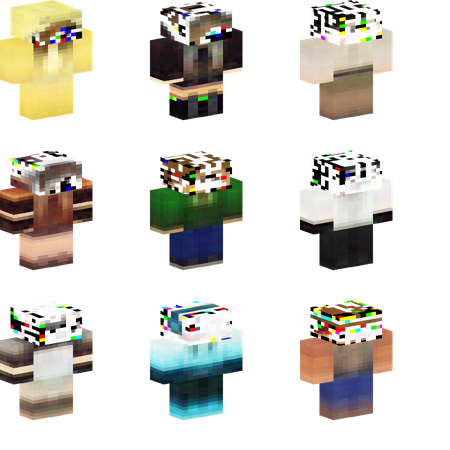

In [12]:
AE = tf.keras.models.load_model('checkpoints/ae011_35000')

batch = next(image_data)[0]
x = AE.predict(batch)
await skin_grid(x)

#### Image Generation

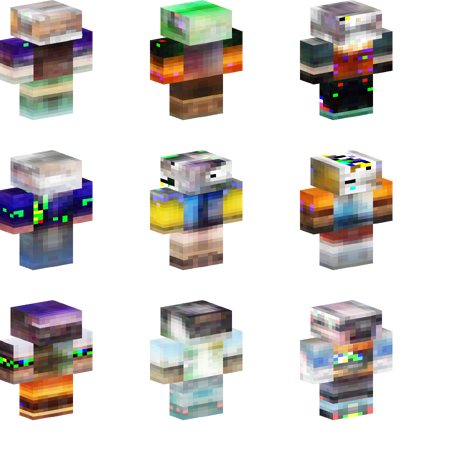

In [13]:
decoder = tf.keras.models.load_model('checkpoints/decoder011_35000')

noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
x = decoder.predict(noise)
await skin_grid(x)

#### Comments
The image compression is good in places, with good structure mostly in the body. Many of the faces are missing which makes it look very bad to the human eye.

The image generation gave surprisingly very similar results to compression, if not better. Again, it struggles most with the face. Probably due to the face having the most variation in the image. THe bottom right image has eyes which make it look particularly good.

### Variational Auto-Encoder

#### Image Compression

Original Images


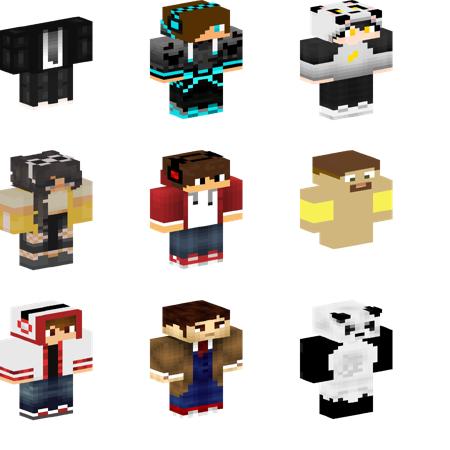

In [14]:
VAE = tf.keras.models.load_model('checkpoints/vae011_50000')

batch = next(image_data)[0]
x = VAE.predict(batch)
print("Original Images")
await skin_grid(batch)

Compressed Images


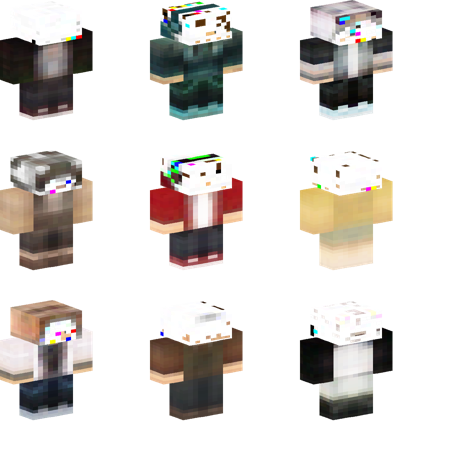

In [15]:
print("Compressed Images")
await skin_grid(x)

#### Image Generation

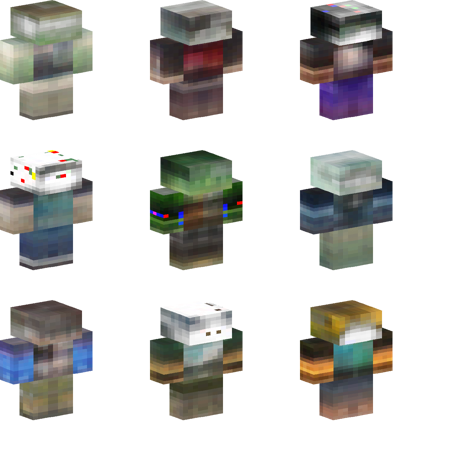

In [18]:
decoder = tf.keras.models.load_model('checkpoints/vdecoder011_50000')

noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
x = decoder.predict(noise)
await skin_grid(x)

#### Comments
Image compression kept the main features of the skin but left entirely transparent places where detail should be. It is interesting that middle left was compressed into a very different but also valid skin. It looks like a bear.

Image generation gave better results as the skins are complete with no holes. There is very little detail on these images but the structure of them is very recognisable. There is consistency to the skins as well, e.g. sleeves and torso colours often match such as in the middle right image.


### Generative Adversarial Network

#### Image Generation

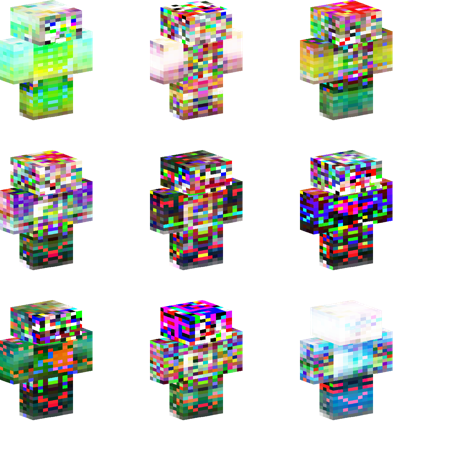

In [55]:
generator = tf.keras.models.load_model('checkpoints/generator006a_100000')

noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
x = generator.predict(noise)
await skin_grid(x)

#### Comments   
I would say that the output of generated images is overall ok, although I think it unlikely that any of these skins would be attractive to the average player. However, there are pieces from most skins that are fairly high quality. For instance, a skin may have very good legs but a poor head, or a good head but a poor torso, etc.   

 I think much of the reason for this result is that the images are RGBA and much of the noise was simply the RGBA channels not lining up, e.g. a line of green values being 1 pixel off can cause a green line to appear as well as a magenta line next to it. This noise is then exacerbated by the low resolution of the image, with only ~1024 pixels being visible at any one time.  
   
This model took ~24 hours to train on my laptop (Google Colab evicted me from its GPU), although I saw continuous improvement throughout. I think that given more training time we may begin to see some high quality results.

### Review
Overall the generated skins were not of particularly high quality, although I do believe there were high quality elements within. For example, the AE/VAE images had very clear structure to them but without detail and the GAN images had some highly detailed elements but little overall structure. I was surprised to see that the Auto-Encoder performed the best in image generation, as the VAE and GAN are more specialised for the task.
   
One idea that I would implement if I had more time would be to convert the images to HSV or a similar format. I think this would help reduce noise in the GAN as it appeared that sometimes the correct structure was there but the RGB colour channels simply weren't lining up. A loss function better designed for multichannel images such as SSIM may also be worth investigation.